In [1]:
from TeraLasso import TeraLasso
from GmGM import GmGM, Dataset

import os
import matplotlib.pyplot as plt
import numpy as np
import timeit

In this notebook we will take a video of a duck, jumble it up, and then reconstruct it with our algorithm!

In [2]:
##############################################
# Utilities for testing video reconstruction #
##############################################

def shuffle_axes(_mat, /, axes: list):
    """
    For every axis, shuffle the matrix on that axis.
    """
    mat = _mat.copy()
    for ax in axes:
        idxs = np.arange(mat.shape[ax])
        np.random.shuffle(idxs)
        slices = [slice(None)] * _mat.ndim
        slices[ax] = idxs
        mat = mat[tuple(slices)]
    return mat

def reconstruct_axes(_mat, /, axes: list, Psis, first_idx=None):
    """
    Uses Psis in a greedy way to work out the best ordering
    of the data.
    """
    orders = []
    for ax in axes:
        Psi = Psis[ax].copy()
        np.fill_diagonal(Psi, 0)
        start = Psi.max(axis=0).argmax()
        if first_idx is None:
            rows = [start]
        else:
            rows = [first_idx]
        for i in range(Psi.shape[0]-1):
            row = rows[-1]

            # Set column to 0 if already used so that it
            # never becomes the strongest connection again
            Psi[:, row] = 0

            # Add strongest connection as next frame
            rows.append(np.argmax(np.abs(Psi[row])))
        orders.append(rows)
    return orders

def get_accuracies(orders):
    accs = []
    names = ('row', 'column', 'frame')
    for name, order in zip(names, orders):
        acc = 0
        for idx, val in enumerate(order):
            if np.abs(order[idx-1] - val) == 1:
                acc += 1
            if np.abs(order[(idx+1)%len(order)] - val) == 1:
                acc += 1
        acc /= 2 * len(order)
        accs.append(acc)
    return accs

(128, 128, 72)


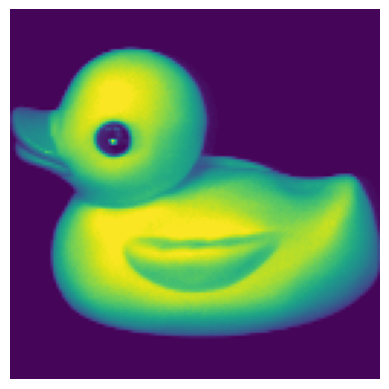

In [3]:
# Find all the files in the data directory
data_dir = os.path.join(os.getcwd(), '../data/coil-20-proc')
files = os.listdir(data_dir)
k = 1

# Format of the duck video is "obj1__{frame}.png"
# We want to grab all files beginning with obj{k}__
files = [f for f in files if f.startswith(f'obj{k}__')]

# And now we want to sort by frame number
def get_frame_number(filename):
    return int(filename.split('__')[1].split('.')[0])

# Sort the files by frame number
files.sort(key=get_frame_number)

# Load them all into a single 3D numpy array
# We'll use the first image to get the shape
first_image = plt.imread(os.path.join(data_dir, files[0]))
image_shape = first_image.shape
image_shape = (image_shape[0], image_shape[1], len(files))

# Now we can allocate the array
images = np.zeros(image_shape)

# And load the images
for i, f in enumerate(files):
    images[:, :, i] = plt.imread(os.path.join(data_dir, f))

print(images.shape)

fig, ax = plt.subplots()
ax.set_axis_off()
im = ax.imshow(images[..., 0], cmap='viridis')

(128, 128, 72)


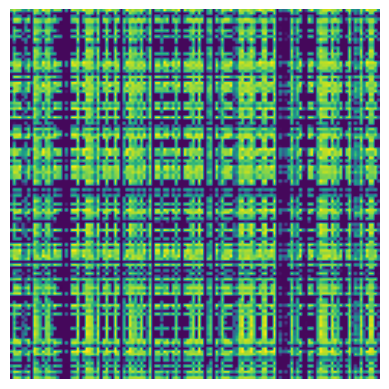

In [4]:
shuffled = shuffle_axes(images, [0, 1, 2])
print(shuffled.shape)

# Plot the shuffled data
fig, ax = plt.subplots()
ax.set_axis_off()
im = ax.imshow(shuffled[..., 0], cmap='viridis')
fig.savefig("out_figs/shuffled-duck.pdf")

In [5]:
images_dataset = Dataset(
    dataset={'video': images.reshape(-1, *images.shape)},
    structure={'video': ('', 'row', 'column', 'frame')},
)
shuffled_dataset = Dataset(
    dataset={'video': shuffled},
    structure={'video': ('row', 'column', 'frame')},
)

## GmGM

### w/o nonpara

In [6]:
# Run GmGM on unshuffled to calculate accuracy
precisions = GmGM(images_dataset, random_state=1).precision_matrices

# "Reconstruct"
orders = reconstruct_axes(
    images,
    [0, 1, 2],
    [
        np.abs(precisions["row"]),
        np.abs(precisions["column"]),
        np.abs(precisions["frame"]),
    ]
)

print("GmGM ", get_accuracies(orders))

GmGM  [0.890625, 0.9375, 0.9444444444444444]


In [7]:
def to_time() -> None:
    GmGM(images_dataset)

np.mean(timeit.repeat(to_time, number=1, repeat=10))

0.6978521043000004

### w/ nonpara

In [8]:
# Run GmGM on unshuffled to calculate accuracy
precisions = GmGM(images_dataset, use_nonparanormal_skeptic=True, random_state=1).precision_matrices

# "Reconstruct"
orders = reconstruct_axes(
    images,
    [0, 1, 2],
    [
        np.abs(precisions["row"]),
        np.abs(precisions["column"]),
        np.abs(precisions["frame"]),
    ]
)

print("GmGMnp ", get_accuracies(orders))

GmGMnp  [0.90625, 0.890625, 0.9305555555555556]


In [9]:
def to_time() -> None:
    GmGM(images_dataset, use_nonparanormal_skeptic=True)

np.mean(timeit.repeat(to_time, number=1, repeat=10))

0.7037979167000004

### image for paper

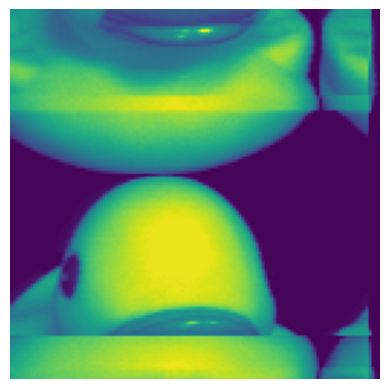

In [10]:
# Run GmGM on it
precisions = GmGM(shuffled_dataset, use_nonparanormal_skeptic=True, random_state=1).precision_matrices

# Recover the axes
orders = reconstruct_axes(
    shuffled,
    [0, 1, 2],
    [
        np.abs(precisions["row"]),
        np.abs(precisions["column"]),
        np.abs(precisions["frame"]),
    ]
)

# Reconstruct the video
unshuffled = shuffled[orders[0]][:, orders[1]][:, :, orders[2]]

# Display the unshuffled video
fig, ax = plt.subplots()
ax.set_axis_off()
im = ax.imshow(unshuffled[:, :, 0], cmap='viridis')
fig.savefig("out_figs/unshuffled-duck.pdf")

## GmGM-20pc

### w/o nonpara

In [11]:
# Run GmGM on unshuffled to calculate accuracy
precisions = GmGM(images_dataset, n_comps=20, random_state=1).precision_matrices

# "Reconstruct"
orders = reconstruct_axes(
    images,
    [0, 1, 2],
    [
        np.abs(precisions["row"]),
        np.abs(precisions["column"]),
        np.abs(precisions["frame"]),
    ]
)

print("GmGM ", get_accuracies(orders))

GmGM  [0.9921875, 0.9921875, 0.9861111111111112]


In [12]:
def to_time() -> None:
    GmGM(images_dataset, n_comps=20)

np.mean(timeit.repeat(to_time, number=1, repeat=10))

0.9788433916999985

### image for paper

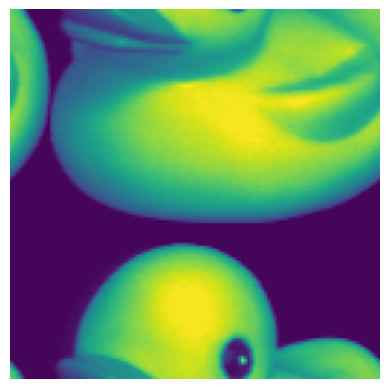

In [13]:
# Run GmGM on it
precisions = GmGM(shuffled_dataset, n_comps=20, random_state=1).precision_matrices

# Recover the axes
orders = reconstruct_axes(
    shuffled,
    [0, 1, 2],
    [
        np.abs(precisions["row"]),
        np.abs(precisions["column"]),
        np.abs(precisions["frame"]),
    ]
)

# Reconstruct the video
unshuffled = shuffled[orders[0]][:, orders[1]][:, :, orders[2]]

# Display the unshuffled video
fig, ax = plt.subplots()
ax.set_axis_off()
im = ax.imshow(unshuffled[:, :, 0], cmap='viridis')
fig.savefig("out_figs/unshuffled-duck-ncomps=20.pdf")

### w/ nonpara

In [14]:
# Run GmGM on unshuffled to calculate accuracy
precisions = GmGM(images_dataset, n_comps=20, use_nonparanormal_skeptic=True, nonparanormal_evec_backend="COCA", random_state=1).precision_matrices

# "Reconstruct"
orders = reconstruct_axes(
    images,
    [0, 1, 2],
    [
        np.abs(precisions["row"]),
        np.abs(precisions["column"]),
        np.abs(precisions["frame"]),
    ]
)

print("GmGM ", get_accuracies(orders))

GmGM  [0.9375, 0.96875, 0.8611111111111112]


In [15]:
def to_time() -> None:
    GmGM(images_dataset, use_nonparanormal_skeptic=True, n_comps=20, nonparanormal_evec_backend="COCA", random_state=1)

np.mean(timeit.repeat(to_time, number=1, repeat=10))

14.297784641700005

## TeraLasso

### w/o nonpara

In [16]:
# Run GmGM on unshuffled to calculate accuracy
precisions = {
    axis: precision.toarray()
    for axis, precision
    in TeraLasso(images_dataset, 0).precision_matrices.items()
}
# "Reconstruct"
orders = reconstruct_axes(
    images,
    [0, 1, 2],
    [
        np.abs(precisions["row"]),
        np.abs(precisions["column"]),
        np.abs(precisions["frame"]),
    ]
)

print("TeraLasso ", get_accuracies(orders))

TeraLasso  [0.875, 0.9375, 0.9305555555555556]


In [17]:
def to_time() -> None:
    TeraLasso(images_dataset, 0)

np.mean(timeit.repeat(to_time, number=1, repeat=10))

4.611155304200008

### w/ nonpara

In [18]:
# Run GmGM on unshuffled to calculate accuracy
precisions = {
    axis: precision.toarray()
    for axis, precision
    in TeraLasso(images_dataset, 0, use_nonparanormal_skeptic=True).precision_matrices.items()
}

# "Reconstruct"
orders = reconstruct_axes(
    images,
    [0, 1, 2],
    [
        np.abs(precisions["row"]),
        np.abs(precisions["column"]),
        np.abs(precisions["frame"]),
    ]
)

print("TeraLasso ", get_accuracies(orders))

TeraLasso  [0.078125, 0.1328125, 0.1388888888888889]


In [19]:
def to_time() -> None:
    TeraLasso(images_dataset, 0, use_nonparanormal_skeptic=True)

np.mean(timeit.repeat(to_time, number=1, repeat=10))

0.33621822080000074